In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import zipfile
import os

In [ ]:
!unzip /content/drive/MyDrive/amb.zip

Streaming output truncated to the last 5000 lines.
  inflating: amb/train/2/T_ambient_20191007_080509_2_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_3_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_4_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_5_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_6_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_7_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_8_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_080509_9_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000_10_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000_11_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000_12_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000_1_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000_2_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000_3_CSWT.jpg  
  inflating: amb/train/2/T_ambient_20191007_120000

In [ ]:
data_dir = '/content/amb'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ]),
}

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(2208, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 2)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from sklearn.metrics import precision_score, recall_score

epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_predictions_train = []
    all_labels_train = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Store predictions and labels for precision and recall
        all_predictions_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Calculate precision and recall for training
    train_precision = precision_score(all_labels_train, all_predictions_train, average='weighted')
    train_recall = recall_score(all_labels_train, all_predictions_train, average='weighted')

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_predictions_val = []
    all_labels_val = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Store predictions and labels for precision and recall
            all_predictions_val.extend(predicted.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())

    val_loss = running_val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val

    # Calculate precision and recall for validation
    val_precision = precision_score(all_labels_val, all_predictions_val, average='weighted')
    val_recall = recall_score(all_labels_val, all_predictions_val, average='weighted',zero_division=1)

    # Print training and validation metrics for the epoch
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation Precision: {val_precision:.2f}, Validation Recall: {val_recall:.2f}\n")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training Loss: 0.7495, Training Accuracy: 77.84%, Training Precision: 0.80, Training Recall: 0.78
Validation Loss: 0.3049, Validation Accuracy: 86.49%, Validation Precision: 0.87, Validation Recall: 0.86

Epoch 2/10
Training Loss: 0.2610, Training Accuracy: 88.80%, Training Precision: 0.89, Training Recall: 0.89
Validation Loss: 0.3196, Validation Accuracy: 85.91%, Validation Precision: 0.86, Validation Recall: 0.86

Epoch 3/10
Training Loss: 0.1689, Training Accuracy: 93.18%, Training Precision: 0.93, Training Recall: 0.93
Validation Loss: 0.2205, Validation Accuracy: 90.94%, Validation Precision: 0.91, Validation Recall: 0.91

Epoch 4/10
Training Loss: 0.1216, Training Accuracy: 95.51%, Training Precision: 0.96, Training Recall: 0.96
Validation Loss: 0.2819, Validation Accuracy: 89.45%, Validation Precision: 0.90, Validation Recall: 0.89

Epoch 5/10
Training Loss: 0.0874, Training Accuracy: 96.68%, Training Precision: 0.97, Training Recall: 0.97
Validation Loss: 0.2515, Validation Ac

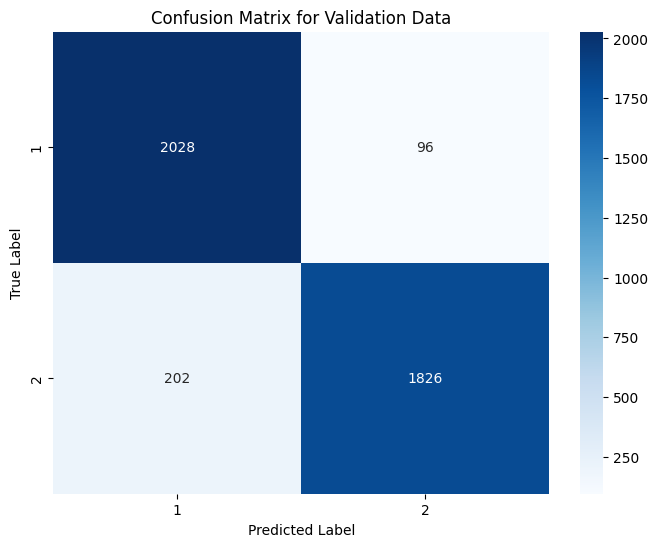

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Evaluation for validation set (test_loader in your case)
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
model.summary()

AttributeError: 'GoogLeNet' object has no attribute 'summary'

In [ ]:
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track